In [51]:
import numpy as np
import pandas as pd
from numpy import array
# from random import randint
# from sklearn.utils import shuffle
# from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.model_selection import ParameterGrid

# from sklearn.metrics import confusion_matrix
# import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format ='svg'
plt.style.use('ggplot')

### Data Prep and Visualization

In [52]:
#read from csv
df=pd.read_csv('data/univariate/kenya/ken_brt_lstm.csv')
print('Birth Rate Dataset: ')
df.head(10)

Birth Rate Dataset: 


,year,value
0,1960,51.156
1,1961,51.068
2,1962,50.976
3,1963,50.887
4,1964,50.807
5,1965,50.748
6,1966,50.723
7,1967,50.731
8,1968,50.768
9,1969,50.825


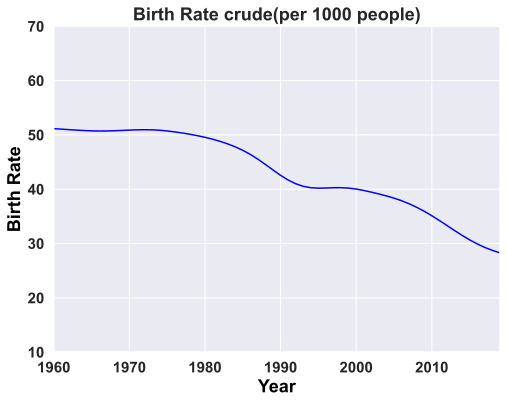

In [74]:
#visualize csv data
plt.plot(df['year'],df['value'], color = 'blue')
plt.xlim([1960, 2019])
plt.ylim([10,70])
plt.xlabel('Year', fontsize = 18, fontweight = 'bold', color ='black')
plt.ylabel('Birth Rate', fontsize = 18, fontweight = 'bold', color ='black')
plt.xticks(fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 15, fontweight = 'bold')
plt.title('Birth Rate crude(per 1000 people)', fontsize = 18, fontweight = 'bold')
plt.show()

### Data preparation into train and test datasets

In [54]:
#sliding window used in spliting the sequence
lag = 3 

training_df = df[df['year']<2010].copy()
mape_training_values = training_df.iloc[lag:, 1:].values
training_years = training_df.iloc[lag:, :].reset_index()
training_data = training_df.iloc[:, 1:].values

#test data: use 2007 to get 10 years due to shifting 
test_data = df[df['year']>=2007].copy().reset_index() 
mape_test_values = test_data.iloc[lag:, 2:].values
test_years = test_data.iloc[lag:, 1:2].reset_index()
test_data = test_data.iloc[:, 2:].values
 
#features
n_features = 1

training_data

array([[51.156],
       [51.068],
       [50.976],
       [50.887],
       [50.807],
       [50.748],
       [50.723],
       [50.731],
       [50.768],
       [50.825],
       [50.887],
       [50.938],
       [50.958],
       [50.935],
       [50.859],
       [50.732],
       [50.56 ],
       [50.356],
       [50.125],
       [49.863],
       [49.564],
       [49.219],
       [48.817],
       [48.349],
       [47.808],
       [47.171],
       [46.409],
       [45.529],
       [44.56 ],
       [43.544],
       [42.56 ],
       [41.698],
       [41.015],
       [40.542],
       [40.28 ],
       [40.196],
       [40.226],
       [40.282],
       [40.289],
       [40.212],
       [40.037],
       [39.777],
       [39.468],
       [39.135],
       [38.773],
       [38.366],
       [37.89 ],
       [37.33 ],
       [36.678],
       [35.942]])

In [55]:
#split the data set into time steps that predict the next step: X for samples, y for labels (actual output)

def split_sequence(sequence, lag):
    print(len(sequence))
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + lag
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

In [75]:
#prepare the data for training
#split into samples and labels
x, y = split_sequence(training_data, lag)
print('Training samples: ')
print('shape: ',x.shape)
print(x)


50
Training samples: 
shape:  (47, 3, 1)
[[[51.156]
  [51.068]
  [50.976]]

 [[51.068]
  [50.976]
  [50.887]]

 [[50.976]
  [50.887]
  [50.807]]

 [[50.887]
  [50.807]
  [50.748]]

 [[50.807]
  [50.748]
  [50.723]]

 [[50.748]
  [50.723]
  [50.731]]

 [[50.723]
  [50.731]
  [50.768]]

 [[50.731]
  [50.768]
  [50.825]]

 [[50.768]
  [50.825]
  [50.887]]

 [[50.825]
  [50.887]
  [50.938]]

 [[50.887]
  [50.938]
  [50.958]]

 [[50.938]
  [50.958]
  [50.935]]

 [[50.958]
  [50.935]
  [50.859]]

 [[50.935]
  [50.859]
  [50.732]]

 [[50.859]
  [50.732]
  [50.56 ]]

 [[50.732]
  [50.56 ]
  [50.356]]

 [[50.56 ]
  [50.356]
  [50.125]]

 [[50.356]
  [50.125]
  [49.863]]

 [[50.125]
  [49.863]
  [49.564]]

 [[49.863]
  [49.564]
  [49.219]]

 [[49.564]
  [49.219]
  [48.817]]

 [[49.219]
  [48.817]
  [48.349]]

 [[48.817]
  [48.349]
  [47.808]]

 [[48.349]
  [47.808]
  [47.171]]

 [[47.808]
  [47.171]
  [46.409]]

 [[47.171]
  [46.409]
  [45.529]]

 [[46.409]
  [45.529]
  [44.56 ]]

 [[45.529]
  [

In [57]:
#Prep the test data
x_test, y_test = split_sequence(test_data, lag)
print('Test samples: ')
print('Shape: ',x_test.shape)
print(x_test)

13
Test samples: 
Shape:  (10, 3, 1)
[[[37.33 ]
  [36.678]
  [35.942]]

 [[36.678]
  [35.942]
  [35.128]]

 [[35.942]
  [35.128]
  [34.249]]

 [[35.128]
  [34.249]
  [33.333]]

 [[34.249]
  [33.333]
  [32.415]]

 [[33.333]
  [32.415]
  [31.522]]

 [[32.415]
  [31.522]
  [30.688]]

 [[31.522]
  [30.688]
  [29.943]]

 [[30.688]
  [29.943]
  [29.296]]

 [[29.943]
  [29.296]
  [28.748]]]


## Hyperparameter Tuning

In [58]:
#select possible parameters combination using grid search

param_grid = {  
    'n_epoch': [20,50,100],
    'n_units': [40,50,60],
    'n_timesteps':(1,2,3)
}

grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)


Total Possible Models 27


In [59]:
#use MAPE to determine the combination with the lowest error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
model_parameters = pd.DataFrame(columns = ['training_MAPE','test_MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)

    model = Sequential([
        LSTM(units=p['n_units'], input_shape=(p['n_timesteps'], n_features), activation='relu',return_sequences=True),
        LSTM(p['n_units'], activation='relu',return_sequences=True),
        LSTM(p['n_units'], activation='relu'),
        Dense(units=1)
    ])
    #compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['accuracy'])
    
    #train the model
    model.fit(x, y, batch_size=1, validation_split=0.1, epochs=p['n_epoch'], verbose=2)

    #Predict
    training_forecast = model.predict(x, batch_size = 1, verbose = 2)
    test_forecast = model.predict(x_test, batch_size = 1, verbose = 2)
    
    training_mape = mean_absolute_percentage_error(mape_training_values,training_forecast,)
    test_mape = mean_absolute_percentage_error(mape_test_values,test_forecast)
    print('Training MAPE-------------------',training_mape)
    print('Test MAPE-------------------',test_mape)
    model_parameters = model_parameters.append({'training_MAPE':training_mape,
                                                'test_MAPE':test_mape,
                                                'Parameters':p},ignore_index=True)
    

{'n_epoch': 20, 'n_timesteps': 1, 'n_units': 40}
Epoch 1/20
42/42 - 2s - loss: 241.0157 - accuracy: 0.0000e+00 - val_loss: 0.8214 - val_accuracy: 0.0000e+00
Epoch 2/20
42/42 - 0s - loss: 1.2850 - accuracy: 0.0000e+00 - val_loss: 1.2989 - val_accuracy: 0.0000e+00
Epoch 3/20
42/42 - 0s - loss: 1.6913 - accuracy: 0.0000e+00 - val_loss: 1.7981 - val_accuracy: 0.0000e+00
Epoch 4/20
42/42 - 0s - loss: 1.5151 - accuracy: 0.0000e+00 - val_loss: 0.3861 - val_accuracy: 0.0000e+00
Epoch 5/20
42/42 - 0s - loss: 4.5079 - accuracy: 0.0000e+00 - val_loss: 7.3809 - val_accuracy: 0.0000e+00
Epoch 6/20
42/42 - 0s - loss: 6.0787 - accuracy: 0.0000e+00 - val_loss: 3.7252 - val_accuracy: 0.0000e+00
Epoch 7/20
42/42 - 0s - loss: 2.4032 - accuracy: 0.0000e+00 - val_loss: 4.8146 - val_accuracy: 0.0000e+00
Epoch 8/20
42/42 - 0s - loss: 2.8568 - accuracy: 0.0000e+00 - val_loss: 0.3920 - val_accuracy: 0.0000e+00
Epoch 9/20
42/42 - 0s - loss: 3.0808 - accuracy: 0.0000e+00 - val_loss: 0.0544 - val_accuracy: 0.0000

In [61]:
parameters = model_parameters.sort_values(by=['test_MAPE'])
parameters = parameters.reset_index(drop=True)

n_epoch = parameters['Parameters'][0]['n_epoch']
n_timesteps = parameters['Parameters'][0]['n_timesteps']
n_units = parameters['Parameters'][0]['n_units']

parameters.head(10)


,training_MAPE,test_MAPE,Parameters
0,2.256904,1.078233,"{'n_epoch': 20, 'n_timesteps': 1, 'n_units': 60}"
1,3.072068,1.124862,"{'n_epoch': 100, 'n_timesteps': 1, 'n_units': 60}"
2,2.934401,1.233709,"{'n_epoch': 50, 'n_timesteps': 3, 'n_units': 50}"
3,2.778848,1.447509,"{'n_epoch': 20, 'n_timesteps': 2, 'n_units': 60}"
4,4.151288,1.477858,"{'n_epoch': 100, 'n_timesteps': 1, 'n_units': 50}"
5,4.474320,1.485736,"{'n_epoch': 50, 'n_timesteps': 2, 'n_units': 50}"
6,4.442212,1.683027,"{'n_epoch': 20, 'n_timesteps': 1, 'n_units': 50}"
7,4.527408,1.712144,"{'n_epoch': 20, 'n_timesteps': 3, 'n_units': 50}"
8,1.748808,1.872838,"{'n_epoch': 50, 'n_timesteps': 2, 'n_units': 60}"
9,1.283881,2.085057,"{'n_epoch': 100, 'n_timesteps': 2, 'n_units': 60}"


In [62]:
n_model = Sequential([
        LSTM(units=n_units, input_shape=(n_timesteps, n_features), activation='relu',return_sequences=True),
        LSTM(n_units, activation='relu',return_sequences=True),
        LSTM(n_units, activation='relu'),
        Dense(units=1)
    ])
n_model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_171 (LSTM)              (None, 1, 60)             14880     
_________________________________________________________________
lstm_172 (LSTM)              (None, 1, 60)             29040     
_________________________________________________________________
lstm_173 (LSTM)              (None, 60)                29040     
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 61        
Total params: 73,021
Trainable params: 73,021
Non-trainable params: 0
_________________________________________________________________


In [63]:
# loop through a count to compile and train the model
cnt = 5

# Question: how do I apply the random numbers in the loop?
rng = np.random.default_rng()
rng.random(cnt)


for p in range(cnt):
    #compile the model
    n_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['accuracy'])

    #train the model
    history =  n_model.fit(x, y, batch_size=1, validation_split=0.1, epochs=n_epoch, verbose=2)

    #Predict
    training_forecast = model.predict(x, batch_size = 1, verbose = 2)
    test_forecast = n_model.predict(x_test, batch_size = 1, verbose = 2)

    cnt = cnt-1

    print ('count', cnt)


Epoch 1/20
42/42 - 2s - loss: 210.1246 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 2/20
42/42 - 0s - loss: 4.9547 - accuracy: 0.0000e+00 - val_loss: 0.4830 - val_accuracy: 0.0000e+00
Epoch 3/20
42/42 - 0s - loss: 3.2513 - accuracy: 0.0000e+00 - val_loss: 0.3065 - val_accuracy: 0.0000e+00
Epoch 4/20
42/42 - 0s - loss: 2.2799 - accuracy: 0.0000e+00 - val_loss: 6.2463 - val_accuracy: 0.0000e+00
Epoch 5/20
42/42 - 0s - loss: 4.3578 - accuracy: 0.0000e+00 - val_loss: 1.4564 - val_accuracy: 0.0000e+00
Epoch 6/20
42/42 - 0s - loss: 3.1032 - accuracy: 0.0000e+00 - val_loss: 0.0591 - val_accuracy: 0.0000e+00
Epoch 7/20
42/42 - 0s - loss: 4.5038 - accuracy: 0.0000e+00 - val_loss: 1.3701 - val_accuracy: 0.0000e+00
Epoch 8/20
42/42 - 0s - loss: 6.6585 - accuracy: 0.0000e+00 - val_loss: 0.0764 - val_accuracy: 0.0000e+00
Epoch 9/20
42/42 - 0s - loss: 3.7507 - accuracy: 0.0000e+00 - val_loss: 0.1001 - val_accuracy: 0.0000e+00
Epoch 10/20
42/42 - 0s - loss: 3.1783 - accu

Text(0.5, 1.0, 'Model Accuracy')

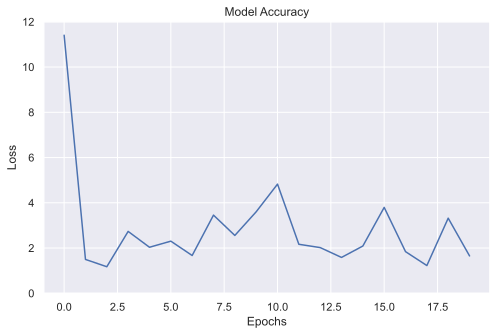

In [77]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.ylim([0, 12])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [65]:
trained_df = pd.DataFrame(training_forecast, columns = ['value'])
trained_df['year'] = training_years['year'] 
trained_df

,value,year
0,50.158459,1963
1,50.068748,1964
2,49.978630,1965
3,49.895386,1966
4,49.827705,1967
5,49.786469,1968
6,49.778515,1969
7,49.801029,1970
8,49.847187,1971
9,49.905323,1972


In [66]:
tested_df = pd.DataFrame(test_forecast, columns = ['value'])
tested_df['year'] = test_years['year']
tested_df

,value,year
0,36.936157,2010
1,36.239697,2011
2,35.462620,2012
3,34.615288,2013
4,33.717499,2014
5,32.799271,2015
6,31.893129,2016
7,31.028587,2017
8,30.236008,2018
9,29.536242,2019


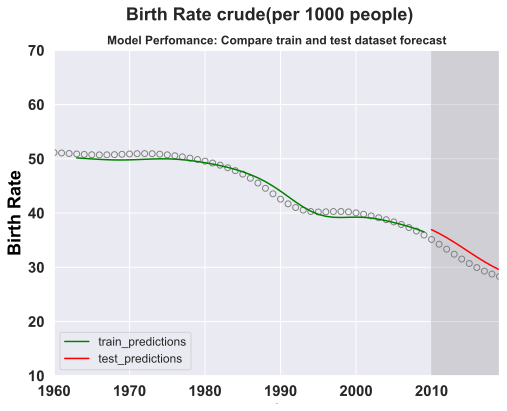

In [67]:
sns.set(rc={'figure.figsize':(8,6)})
plt.axvspan(xmin =2010,
            xmax =2019,
            color = 'grey',
            alpha = 0.25)
plt.scatter(df['year'], df['value'], facecolors = 'none', edgecolors = 'grey')
plt.plot(trained_df['year'], trained_df['value'], color = 'green', label = 'train_predictions')
plt.plot(tested_df['year'], tested_df['value'], color = 'red', label = 'test_predictions')

plt.xlim([1960, 2019])
plt.ylim([10,70])
plt.xlabel('Year', fontsize = 1, fontweight = 'bold', color ='black')
plt.ylabel('Birth Rate', fontsize = 18, fontweight = 'bold', color ='black')
plt.xticks(fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 15, fontweight = 'bold')

plt.suptitle('Birth Rate crude(per 1000 people)', fontsize = 18, fontweight = 'bold')
plt.title('Model Perfomance: Compare train and test dataset forecast', fontsize = 12, fontweight = 'bold')
plt.legend(loc='lower left', fontsize = 12)
plt.show()

### Calculate RMSE

In [68]:
# report performance
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(y, training_forecast))
print(' Test RMSE: %.3f' %  rmse)

 Test RMSE: 0.778


## Predict the next 10 years

In [69]:
# get the last birth rates based on the lag
d = df['value']
prediction_list = d[-lag:].values

# predict the next 10 years
num_prediction = 10

for i in range(num_prediction):
    
    #always get the last birth rates to predict the next
    x_predict = prediction_list[-lag:]
    x_predict = x_predict.reshape(1,lag,1)
    out = model.predict(x_predict)[0][0]
 
    #add predicted birth rate to list
    prediction_list = np.append(prediction_list, out)

#remove the initial birth rates
prediction_list = prediction_list[lag:]
prediction_list

array([27.77336311, 27.2387867 , 26.74081993, 26.19543457, 25.64840126,
       25.10842514, 24.53648567, 23.96012688, 23.37569237, 22.76534843])

In [70]:
#process years
last_year = df['year'].values[-1]
predicted_years = []
for i in range(num_prediction):
    last_year = last_year +1
    predicted_years.append(last_year)
predicted_years

[2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029]

In [71]:
#create dataframe for predicted birthrate
d = {'year':predicted_years, 'value':prediction_list}
forecasted = pd.DataFrame(data = d)
forecasted

,year,value
0,2020,27.773363
1,2021,27.238787
2,2022,26.740820
3,2023,26.195435
4,2024,25.648401
5,2025,25.108425
6,2026,24.536486
7,2027,23.960127
8,2028,23.375692
9,2029,22.765348


#### Visualize forecasted values

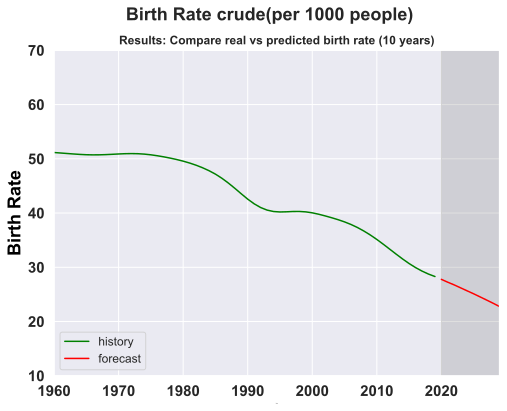

In [72]:
sns.set(rc={'figure.figsize':(8,6)})
plt.axvspan(xmin =2020,
            xmax =2029,
            color = 'grey',
            alpha = 0.25)
plt.plot(df['year'], df['value'], color = 'green', label = 'history')
plt.plot(forecasted['year'], forecasted['value'], color = 'red', label = 'forecast')

plt.xlim([1960, 2029])
plt.ylim([10,70])
plt.xlabel('Year', fontsize = 1, fontweight = 'bold', color ='black')
plt.ylabel('Birth Rate', fontsize = 18, fontweight = 'bold', color ='black')
plt.xticks(fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 15, fontweight = 'bold')
plt.suptitle('Birth Rate crude(per 1000 people)', fontsize = 18, fontweight = 'bold')
plt.title('Results: Compare real vs predicted birth rate (10 years)', fontsize = 12, fontweight = 'bold')
plt.legend(loc='lower left', fontsize = 12)
plt.show()

### Compare LSTM and Prophet forecasted values

In [78]:
#add prophet values to df
prophet_forecasted = pd.read_csv('prophet_forecasted_birthrate.csv')
forecasted['prophet_forecasted'] = prophet_forecasted
forecasted

,year,value,prophet_forecasted
0,2020,27.773363,27.007508
1,2021,27.238787,26.211701
2,2022,26.740820,25.415893
3,2023,26.195435,24.620086
4,2024,25.648401,23.822099
5,2025,25.108425,23.026291
6,2026,24.536486,22.230484
7,2027,23.960127,21.434677
8,2028,23.375692,20.636689
9,2029,22.765348,19.840882


In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
plt.axvspan(xmin =2020,
            xmax =2029,
            color = 'grey',
            alpha = 0.25)
# plt.scatter(df['year'], df['value'], facecolors = 'none', edgecolors = 'grey')
plt.plot(df['year'], df['value'], color = 'green', label = 'history')
plt.plot(forecasted['year'], forecasted['value'], color = 'red', label = 'lstm forecast')
plt.plot(forecasted['year'], forecasted['prophet_forecasted'], color = 'blue', label = 'prophet forecast')

plt.xlim([1960, 2029])
plt.ylim([10,70])
plt.xlabel('Year', fontsize = 1, fontweight = 'bold', color ='black')
plt.ylabel('Birth Rate', fontsize = 18, fontweight = 'bold', color ='black')
plt.xticks(fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 15, fontweight = 'bold')
plt.suptitle('Birth Rate crude(per 1000 people)', fontsize = 18, fontweight = 'bold')
plt.title('Models Comparison: Compare LSTM and Prophet prediction on birth rate', fontsize = 12, fontweight = 'bold')
plt.legend(loc='lower left', fontsize = 12)
plt.show()